Test JaxTracer VS Legacy Raytracer

Import Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

#add path
sys.path.insert(0, '../../src/simulator')     # import path/to/synthpy

import config
config.jax_init()

import beam as beam_initialiser
import propagator as p
import diagnostics as diag

import importlib
importlib.reload(beam_initialiser)
importlib.reload(p)
importlib.reload(diag)


Disabling python multi-threading...

Initialising jax...

Default jax backend: cpu
Available devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11), CpuDevice(id=12), CpuDevice(id=13), CpuDevice(id=14), CpuDevice(id=15)]


<module 'diagnostics' from '/home/administrator/Work/UROP_ICL_Internship/synthPy/evaluation/domain_testing/../../src/simulator/diagnostics.py'>

In [2]:
import jax
import jax.numpy as jnp
import equinox as eqx

from utils import mem_conversion
from printing import colour
from utils import dalloc
from utils import domain_estimate

class ScalarDomain(eqx.Module):
    """
    A class to hold and generate scalar domains.
    This contains also the method to propagate rays through the scalar domain
    """

    inv_brems: bool
    phaseshift: bool
    B_on: bool

    probing_direction: str

    ne_type: str

    leeway_factor: jnp.float32

    x_length: jnp.int32
    y_length: jnp.int32
    z_length: jnp.int32

    lengths: jax.Array

    x_n: jnp.int32
    y_n: jnp.int32
    z_n: jnp.int32

    dims: jax.Array

    x: jax.Array
    y: jax.Array
    z: jax.Array

    coordinates: jax.Array

    XX: jax.Array
    YY: jax.Array
    ZZ: jax.Array

    ne: jax.Array

    B: jax.Array
    Te: jax.Array
    Z: jax.Array

    region_count: jnp.int32

    coord_backup: jax.Array
    future_dims: jax.Array

    debug: bool

    def __init__(self, lengths, dims, *, ne_type = None, inv_brems = False, phaseshift = False, B_on = False, probing_direction = 'z', auto_batching = True, iteration = 1, region_count = 1, leeway_factor = None, coord_backup = None, future_dims = None, debug = False):
        """
        Example:
            N_V = 100
            M_V = 2*N_V+1
            ne_extent = 5.0e-3
            ne_x = jnp.linspace(-ne_extent,ne_extent,M_V)
            ne_y = jnp.linspace(-ne_extent,ne_extent,M_V)
            ne_z = jnp.linspace(-ne_extent,ne_extent,M_V)

        Args:
            x (float array): x coordinates, m
            y (float array): y coordinates, m
            z (float array): z coordinates, m
            extent (float): physical size, m
        """

        # initalise to none for equinox incase not initialised properly later on
        self.ne = None
        self.B = None
        self.Te = None
        self.Z = None

        # Logical switches
        self.inv_brems = inv_brems
        self.phaseshift = phaseshift
        self.B_on = B_on

        self.probing_direction = probing_direction

        self.ne_type = ne_type

        # working with 10% leeway in estimate for now
        if leeway_factor is not None:
            self.leeway_factor = leeway_factor
        else:
            self.leeway_factor = 1.1

        self.debug = debug

        valid_types = (int, float, jnp.int32)

        ##
        ## NOT FORCING THESE CONVERSIONS MAY CAUSE ISSUES WITH EQUINOX CLASS LATER DOWN THE LINE DEPENDING ON USER INPUT
        ##

        # if 1 length given, assumes all are the same
        if isinstance(lengths, valid_types):
            self.x_length, self.y_length, self.z_length = lengths, lengths, lengths
            self.lengths = jnp.array([lengths, lengths, lengths])
        # if array given, checks len = 3 and assigns accordingly
        else:
            if len(lengths) != 3:
                raise Exception('lengths must have len = 3: (x,y,z)')

            self.x_length, self.y_length, self.z_length = lengths[0], lengths[1], lengths[2]
            self.lengths = jnp.array(lengths)

        del lengths
        
        #likewise for dims
        #self.dims = dims
        if isinstance(dims, valid_types):
            self.x_n, self.y_n, self.z_n = dims, dims, dims
            self.dims = jnp.array([dims, dims, dims])
        else:
            if len(dims) != 3:
                raise Exception('n must have len = 3: (x_n, y_n, z_n)')

            self.x_n, self.y_n, self.z_n = dims[0], dims[1], dims[2]
            self.dims = jnp.array(dims)

        del dims
        del valid_types

        predicted_domain_allocation = domain_estimate(self.dims)
        print("Predicted size in memory of domain:", mem_conversion(predicted_domain_allocation))

        if iteration == 1 and auto_batching:
            from jax.lib import xla_bridge
            running_device = xla_bridge.get_backend().platform

            if running_device == 'cpu':
                from psutil import virtual_memory

                free_mem = virtual_memory().available

                print("\nFree memory:", mem_conversion(free_mem))
            elif running_device == 'gpu':
                from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo

                nvmlInit()

                h = nvmlDeviceGetHandleByIndex(0)
                info = nvmlDeviceGetMemoryInfo(h)

                free_mem = info.free

                print("\nMemory prior to domain creation:")
                print(f'total : {mem_conversion(info.total)}')
                print(f'free  : {mem_conversion(info.free)}')
                print(f'used  : {mem_conversion(info.used)}')
            elif running_device == 'tpu':
                free_mem = None
            else:
                assert "\nNo suitable device detected when checking ram/vram available."

            ##
            ## Need to work out the max allocation at any point and that estimated size
            ##

            # 2 for ne and ne_nc in calc_dndr(...) before ne is deleted
            # at peak mem usage ne should have been deleted, therefore this contributes only 1 domain
            # +1 for ne_interp
            # +2 for the 2 sqeuentially repeated domain sized allocations in dndr(...)
            allocation_count = 4

            # up to +5 in calc_dndr(...) depending on the number of extra interps
            if B_on:
                # there are 4 B based interps
                # and they also require a ScalarDomain.B domain sized matrice
                allocation_count += 4
            if inv_brems:
                # unsure how many intermediaries exist at peak mem usage for this allocation - need to check and adjust this
                allocation_count += 1
            if phaseshift:
                allocation_count += 1

            estimate_limit = predicted_domain_allocation * allocation_count * self.leeway_factor
            print("Est. memory limit: {} --> inc. +{}% variance margin.".format(mem_conversion(estimate_limit), jnp.int32((self.leeway_factor - 1) * 100)))

            # when jnp.float32 is not used, will cause overflow error if 64 bit floats are not enabled
            if jnp.float32(estimate_limit) > jnp.float32(free_mem):
                print(colour.BOLD + "\nESTIMATE SUGGESTS DOMAIN CANNOT FIT IN AVAILABLE MEMORY." + colour.END)
                print("--> Auto-batching domain based on memory available and domain size estimate...")

                ##
                ## Used backed up information to re-assign to ScalarDomain in propagator
                ## Then call generate_electron_density_profile(...) and re-do calculations with end of prior domain
                ##

                from math import ceil
                self.region_count = ceil(estimate_limit / free_mem)

                self.coord_backup = jnp.float32(jnp.linspace(
                   -self.lengths[['x', 'y', 'z'].index(self.probing_direction)] / 2,
                    self.lengths[['x', 'y', 'z'].index(self.probing_direction)] / 2,
                       self.dims[['x', 'y', 'z'].index(self.probing_direction)]
                ))

                dim_per_region = self.dims[['x', 'y', 'z'].index(self.probing_direction)] // self.region_count
                self.future_dims = jnp.concatenate([
                    jnp.expand_dims(0, axis = 0), jnp.array([dim_per_region] * self.region_count),
                    jnp.array([self.dims[['x', 'y', 'z'].index(self.probing_direction)] - dim_per_region * self.region_count])
                ])

                print("--> Batching calculation completed. Domain will be split into " + str(self.region_count) + " regions with " + str(dim_per_region) + " dims per region.")
                print(colour.BOLD + "\nWARNING:" + colour.END + " This functionality will cause the solver to run slower due to domain regeneration, for optimal performance, increase the memory available to this program.")
            else:
                self.region_count = 1
        else:
            self.region_count = region_count

        if self.region_count == 1:
            self.coord_backup = None
            self.future_dims = None

            # define coordinate space
            self.x = jnp.float32(jnp.linspace(-self.x_length / 2, self.x_length / 2, self.x_n))
            self.y = jnp.float32(jnp.linspace(-self.y_length / 2, self.y_length / 2, self.y_n))
            self.z = jnp.float32(jnp.linspace(-self.z_length / 2, self.z_length / 2, self.z_n))
        else:
            if iteration != 1:
                self.coord_backup = coord_backup
                self.future_dims = future_dims

            if iteration == 1:
                lower = 0
                upper = 65#self.future_dims[1] + 1
            else:
                lower = 64#jnp.sum(self.future_dims[0:iteration])
                upper = 128#lower + self.future_dims[iteration]

            if self.probing_direction == 'x':
                # define coordinate space
                self.x = self.coord_backup[lower:upper]
                self.y = jnp.float32(jnp.linspace(-self.y_length / 2, self.y_length / 2, self.y_n))
                self.z = jnp.float32(jnp.linspace(-self.z_length / 2, self.z_length / 2, self.z_n))

                self.x_length = self.x[-1] - self.x[0]
                self.lengths = self.lengths.at[0].set(self.x_length)

                self.x_n = len(self.x)
                self.dims = self.dims.at[0].set(self.x_n)
            elif self.probing_direction == 'y':
                # define coordinate space
                self.x = jnp.float32(jnp.linspace(-self.x_length / 2, self.x_length / 2, self.x_n))
                self.y = self.coord_backup[lower:upper]
                self.z = jnp.float32(jnp.linspace(-self.z_length / 2, self.z_length / 2, self.z_n))

                self.y_length = self.y[-1] - self.y[0]
                self.lengths = self.lengths.at[1].set(self.y_length)

                self.y_n = len(self.y)
                self.dims = self.dims.at[1].set(self.y_n)
            elif self.probing_direction == 'z':
                # define coordinate space
                self.x = jnp.float32(jnp.linspace(-self.x_length / 2, self.x_length / 2, self.x_n))
                self.y = jnp.float32(jnp.linspace(-self.y_length / 2, self.y_length / 2, self.y_n))
                self.z = self.coord_backup[lower:upper]

                self.z_length = self.z[-1] - self.z[0]
                self.lengths = self.lengths.at[2].set(self.z_length)

                self.z_n = len(self.z)
                self.dims = self.dims.at[2].set(self.z_n)
            else:
                assert colour.BOLD + "Invalid entry for probing_direction!" + colour.END

        print("\nCoordinates have shape of ({}, {}, {})".format(len(self.x), len(self.y), len(self.z)), end = " --> ")

        if self.x.shape == self.y.shape and self.y.shape == self.z.shape and self.z.shape == self.x.shape:
            self.coordinates = jnp.stack([self.x, self.y, self.z], axis = 1, dtype = jnp.float32)

            print("no padding required.")
        else:
            max_dim = self.dims[0]
            for dimension in self.dims:
                if dimension > max_dim:
                    max_dim = dimension

            # pad coordinates but not arrays themselves, that way only interpolator takes in padded values - no needless extra mem allocation by the domain
            self.coordinates = jnp.stack([
                    jnp.pad(self.x, (0, max_dim - self.x_n), constant_values = jnp.nan),
                    jnp.pad(self.y, (0, max_dim - self.y_n), constant_values = jnp.nan),
                    jnp.pad(self.z, (0, max_dim - self.z_n), constant_values = jnp.nan)
                ], axis = 1)

            print("padded up-to {} entries.".format(max_dim))
            print(" --> x padded with: {} nan's".format(max_dim - self.x_n))
            print(" --> y padded with: {} nan's".format(max_dim - self.y_n))
            print(" --> z padded with: {} nan's".format(max_dim - self.z_n))

        if self.ne_type is not None:
            self.generate_electron_density_profile()
        else:
            assert auto_batching == True, colour.BOLD + "\nne_type must be passed to domain creation in order to utilise auto-batching." + colour.END

            # can't initialise yourself as equinox.Module inherited class is not mutable and self.ne is set during creation -- FIX!
            print("\nWARNING: Electron density profile to generate not passed. You will need to initialise this yourself with a call to this library.")
            print("\t If you run low on memory, you can enforce a manual domain cleanup with a call to ScalarDomain.cleanup()")

            self.XX, self.YY, self.ZZ = jnp.meshgrid(self.x, self.y, self.z, indexing = 'ij', copy = True)#False) - has to be true for jnp

        if self.debug:
            from utils import round_to_n

            print(colour.BOLD + "\nScalarDomain object attribute info:" + colour.END)
            print(" --> lengths: {}, {}, {}".format(self.x_length, self.y_length, self.z_length))
            print(" --> lengths: {}".format(self.lengths))
        
            print("\n --> dims: {}, {}, {}".format(self.x_n, self.y_n, self.z_n))
            print(" --> dims: {}".format(self.dims))

            #arr = jnp.array([self.x[0], self.x[-1], self.y[0], self.y[-1], self.z[0], self.z[-1]])
            aim = 3

            '''
            round_to = find_sig_n(arr[0], aim)
            for i in arr:
                cache = find_sig_n(i, aim)
                if abs(cache) > abs(round_to):
                    round_to = cache

            for i in range(len(arr)):
                arr = arr.at[i].set(jnp.round(arr[i], round_to))
            '''

            print(f"\n --> x, y, z (s,e):",
                " [", round_to_n(self.x[0], aim), ", ", round_to_n(self.x[-1], aim), "],",
                " [", round_to_n(self.y[0], aim), ", ", round_to_n(self.y[-1], aim), "],",
                " [", round_to_n(self.z[0], aim), ", ", round_to_n(self.z[-1], aim), "]",
            sep = "")
            print(" --> their len's: {}, {}, {}".format(len(self.x), len(self.y), len(self.z)))

            if self.region_count != 1 and auto_batching:
                print("\n --> coord_backup: {}".format(
                    round_to_n(self.coord_backup[0], aim),
                    round_to_n(self.coord_backup[-1], aim)))
                print(" --> it's len: {}".format(len(self.coord_backup)))

                print("\n --> future dims: {}".format(self.future_dims))

    def generate_electron_density_profile(self):
        print("\nGenerating test", end = " ")
        if self.ne_type == "test_null":
            print("null -e field...")
            self.XX, _, _ = jnp.meshgrid(self.x, self.y, self.z, indexing = 'ij', copy = True)

            self.YY = None
            self.ZZ = None

            self.test_null()
        elif self.ne_type == "test_slab":
            print("slab -e field...")
            self.XX, _, _ = jnp.meshgrid(self.x, self.y, self.z, indexing = 'ij', copy = True)

            self.YY = None
            self.ZZ = None

            self.test_slab()
        elif self.ne_type == "test_linear_cos":
            print("linear decay periodic -e field...")
            self.XX, self.YY, _ = jnp.meshgrid(self.x, self.y, self.z, indexing = 'ij', copy = True)

            self.ZZ = None

            self.test_linear_cos()
        elif self.ne_type == "test_exponential_cos":
            print("exponential decay periodic -e field...")
            self.XX, self.YY, _ = jnp.meshgrid(self.x, self.y, self.z, indexing = 'ij', copy = True)

            self.ZZ = None

            self.test_exponential_cos()
        else:
            assert "\nNo valid profile detected! Ensure passed name is correct or call yourself."

        self.cleanup()

    def test_null(self):
        """
        Null test, an empty cube
        """

        self.ne = jnp.zeros_like(self.XX)

    def test_slab(self, *, s = 1, ne_0 = 2e23):
        """
        A slab with a linear gradient in x:
        n_e =  ne_0 * (1 + s*x/extent)

        Will cause a ray deflection in x

        Args:
            s (int, optional): scale factor. Defaults to 1.
            ne_0 ([type], optional): mean density. Defaults to 2e23 m^-3.
        """

        self.ne = ne_0 * (1.0 + s * self.XX / self.x_length)

    def test_linear_cos(self, *, s1 = 0.1, s2 = 0.1, ne_0 = 2e23, Ly = 1):
        """
        Linearly growing sinusoidal perturbation

        Args:
            s1 (float, optional): scale of linear growth. Defaults to 0.1.
            s2 (float, optional): amplitude of sinusoidal perturbation. Defaults to 0.1.
            ne_0 ([type], optional): mean electron density. Defaults to 2e23 m^-3.
            Ly (int, optional): spatial scale of sinusoidal perturbation. Defaults to 1.
        """

        self.ne = ne_0 * (1.0 + s1 * self.XX / self.x_length) * (1 + s2 * jnp.cos(2 * jnp.pi * self.YY / Ly))
    
    def test_exponential_cos(self, *, ne_0 = 2e17 * 1e6, Ly = 1e-3, s = -4e-3):
        """
        Exponentially growing/decaying sinusoidal perturbation

        Args:
            ne_0 ([type], optional): mean electron density. Defaults to 1e24 m^-3.
            Ly (int, optional): spatial scale of sinusoidal perturbation. Defaults to 1e-3 m.
            s ([type], optional): scale of exponential change. Defaults to -2e-3 m (exponential decay).
        """

        self.XX = self.XX.at[:, :].set(self.XX / s)
        self.XX = self.XX.at[:, :].set(10 ** self.XX)

        self.YY = self.YY.at[:, :].set(self.YY / Ly)
        self.YY = self.YY.at[:, :].set(jnp.pi * self.YY)
        self.YY = self.YY.at[:, :].set(2 * self.YY)
        self.YY = self.YY.at[:, :].set(jnp.cos(self.YY))
        self.YY = self.YY.at[:, :].set(1 + self.YY)

        # any difference if float32 (or even 64 if changed later) or not? shouldn't be.
        self.ne = self.XX * self.YY
        self.cleanup()

        self.ne = self.ne.at[:, :].set(ne_0 * self.ne)

        #self.ne = jnp.float32(ne_0 * 10 ** (self.XX / s) * (1 + jnp.cos(2 * jnp.pi * self.YY / Ly)))

    def external_ne(self, *, ne):
        """
        Load externally generated grid

        Args:
            ne ([type]): MxMxM grid of density in m^-3
        """

        self.ne = ne

    def external_B(self, *, B):
        """
        Load externally generated grid

        Args:
            B ([type]): MxMxMx3 grid of B field in T
        """

        self.B = B

    def external_Te(self, *, Te, Te_min = 1.0):
        """
        Load externally generated grid

        Args:
            Te ([type]): MxMxM grid of electron temperature in eV
        """

        self.Te = jnp.maximum(Te_min, Te)

    def external_Z(self, *, Z):
        """
        Load externally generated grid

        Args:
            Z ([type]): MxMxM grid of ionisation
        """

        self.Z = Z
        
    def test_B(self, *, Bmax = 1.0):
        """
        A Bz field with a linear gradient in x:
        Bz =  Bmax*x/extent

        Args:
            Bmax ([type], optional): maximum B field, default 1.0 T
        """

        self.B = jnp.zeros(jnp.append(jnp.array(self.XX.shape), 3))
        self.B[:, :, :, 2] = Bmax * self.XX / self.x_length

    def export_scalar_field(self, property: str = 'ne', fname: str = None):
        """
        Export the current scalar electron density profile as a pvti file format, property added for future scalability to export temperature, B-field, etc.

        Args:
            property: str, 'ne': export the electron density (default)
            fname: str, file path and name to save under. A VTI pointed to by a PVTI file are saved in this location. If left blank, the name will default to:
                    ./plasma_PVTI_DD_MM_YYYY_HR_MIN
        """

        import pyvista as pv

        if fname is None:
            import datetime as dt
            year = dt.datetime.now().year
            month = dt.datetime.now().month
            day = dt.datetime.now().day
            min = dt.datetime.now().minute
            hour = dt.datetime.now().hour

            # filename extended to include the name of the property to be exported
            fname = f'./plasma_PVTI_{property}_{day}_{month}_{year}_{hour}_{min}' #default fname to the current date and time 

        if property == 'ne':

            try: #check to ensure electron density has been added
                jnp.shape(self.ne)
                rnec = self.ne
            except:
                raise Exception('No electron density currently loaded!')
        
            # Create the spatial reference  
            grid = pv.ImageData()

            # Set the grid dimensions: shape + 1 because we want to inject our values on
            # the CELL data
            grid.dimensions = jnp.array(rnec.shape) + 1
            # Edit the spatial reference
            grid.origin = (0, 0, 0)  # The bottom left corner of the data set

            #scaling
            x_size = jnp.max(self.x) / ((jnp.shape(self.ne)[0] - 1)//2 )  #assuming centering about the origin
            y_size = jnp.max(self.y) / ((jnp.shape(self.ne)[1] - 1)//2 ) 
            z_size = jnp.max(self.z) / ((jnp.shape(self.ne)[2] - 1)//2 )
            grid.spacing = (x_size, y_size, z_size)  # These are the cell sizes along each axis

            # Add the data values to the cell data
            grid.cell_data["rnec"] = rnec.flatten(order="F")  # Flatten the array

            grid.save(f'{fname}.vti')

            print(f'VTI saved under {fname}.vti')

        #prep values to write the pvti, written to match the exported vti using pyvista

        relative_fname = fname.split('/')[-1]
        spacing_x = (2*jnp.max(self.x))/jnp.shape(self.x)[0]
        spacing_y = (2*jnp.max(self.y))/jnp.shape(self.y)[0]
        spacing_z = (2*jnp.max(self.z))/jnp.shape(self.z)[0]
        content = f"""<?xml version="1.0"?>
                        <VTKFile type="PImageData" version="0.1" byte_order="LittleEndian" header_type="UInt32" compressor="vtkZLibDataCompressor">
                            <PImageData WholeExtent="0 {jnp.shape(self.ne)[0]} 0 {jnp.shape(self.ne)[1]} 0 {jnp.shape(self.ne)[2]}" GhostLevel="0" Origin="0 0 0" Spacing="{spacing_x} {spacing_y} {spacing_z}">
                                <PCellData Scalars="rnec">
                                    <PDataArray type="Float64" Name="rnec">
                                    </PDataArray>
                                </PCellData>
                                <Piece Extent="0 {jnp.shape(self.ne)[0]} 0 {jnp.shape(self.ne)[1]} 0 {jnp.shape(self.ne)[2]}" Source="{relative_fname}.vti"/>
                            </PImageData>
                        </VTKFile>"""
    
        # write file
        with open(f'{fname}.pvti', 'w') as file:
            file.write(content)

        print(f'Scalar Domain electron density succesfully saved under {fname}.pvti !')

    def cleanup(self):
        if self.XX is not None:
            dalloc(self.XX)
        if self.YY is not None:
            dalloc(self.YY)
        if self.ZZ is not None:
            dalloc(self.ZZ)

Create a domain

In [3]:
## Sinusoidal test
N_V       =     100
M_V       =     2 * N_V + 1
ne_extent =     5.0e-3  # 5 mm extent of the electron density cube

# this function doubles the length
ne_x      =     np.linspace(-ne_extent, ne_extent, M_V)
ne_y      =     np.linspace(-ne_extent, ne_extent, M_V)
ne_z      =     np.linspace(-ne_extent, ne_extent, M_V)

# therefore to stay consistent with legacy code, we create extent's and THEN double them
# rather than just setting them to the desired length in the first place
lengths = 2 * jnp.array([ne_extent, ne_extent, ne_extent])

probing_direction = "z"

cos = ScalarDomain(lengths, M_V, ne_type = "test_exponential_cos", probing_direction = probing_direction)
#cos       =     pt.ElectronCube(ne_x, ne_y, ne_z, ne_extent)

#ne_0      =     2e17 * 1e6 #2e17 cm^-3 amplitude density
#Ly        =     1e-3 # 1 mm perturbation wavelength
#s         =     -4e-3 #4 mm exponential growth rate

#cos       =    d.test_exponential_cos(ne_0 = ne_0, Ly = Ly, s = s)

#cos.calc_dndr()
# cos.clear_memory()

Predicted size in memory of domain: 30.977634 MB

Free memory: 4.719673156738281 GB
Est. memory limit: 136.30159 MB --> inc. +10% variance margin.


/tmp/ipykernel_43725/747167995.py:141: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated and will be removed in JAX v0.8.0; use jax.extend.backend.get_backend.
  running_device = xla_bridge.get_backend().platform



Coordinates have shape of (201, 201, 201) --> no padding required.

Generating test exponential decay periodic -e field...


Visualise the electon density cube - this need to be for all line of sight
3 subplots with the xy-plane, yz-plane, zx-plane

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def graph_domain(domain):
    fig, ax = plt.subplots(figsize = (9.5, 9.5))
    fig.subplots_adjust(.15,.15,.95,.95, hspace= 0.5)

    im = ax.imshow(domain.ne[:,:,0].T/1e24, cmap = 'jet', origin = 'lower', extent = [-5,5,-5,5], clim = [0, 8])
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xticks([-5,-2.5, 0, 2.5, 5])
    ax.set_yticks([-5,-2.5, 0, 2.5, 5])

    axins1 = inset_axes(
        ax,
        width="50%",  # width: 50% of parent_bbox width
        height="5%",  # height: 5%
        loc="lower right",
        bbox_to_anchor=(-0.5, -0.2, 1, 1),
        bbox_transform=ax.transAxes,
        borderpad=0,
    )

    axins1.xaxis.set_ticks_position("bottom")
    cbar = plt.colorbar(im, cax=axins1, ticks=[0, 2, 4, 6, 8], shrink=0.4, orientation="horizontal", extend='both')
    cbar.set_label(r'$ n_e(x, y, z_0)$ ($\times 10^{18}$ $cm^{-3}$)', fontsize = 24)
    cbar.ax.tick_params(labelsize = 24)

    ax.set_xlabel('x (mm)', fontsize = 24)
    ax.set_ylabel('y (mm)', fontsize = 24)

    divider = make_axes_locatable(ax)
    axvert  = divider.append_axes('right', size='30%', pad=0.15)
    axhoriz = divider.append_axes('top',   size='30%', pad=0.15)

    profile_vert    =   domain.ne[:,:,0].T.sum(axis = 0)
    profile_vert    =   (profile_vert - profile_vert.min() ) / (profile_vert.max() - profile_vert.min())
    axhoriz.plot(ne_x, profile_vert, lw = 3, c = 'k', alpha = 1)
    axhoriz.set_xlim(-5e-3,5e-3)
    axhoriz.set_ylim(0,1)
    axhoriz.set_ylabel(r'$n_e$(x)', fontsize = 23)


    profile_hor     =   domain.ne[:,:,0].T.sum(axis = 1)
    profile_hor     =   (profile_hor - profile_hor.min() ) / (profile_hor.max() - profile_hor.min())
    profile_hor_theory  =  profile_hor
    axvert.plot(profile_hor, ne_y, lw = 3, c = 'k', alpha = 1)
    axvert.set_ylim(-5e-3,5e-3)
    axvert.set_xlabel(r'$n_e$(z)', fontsize = 23)

    ax.tick_params(axis = 'both', labelsize = 24)

    axvert.set_xticks([])
    axhoriz.set_yticks([])
    axvert.set_yticks([])
    axhoriz.set_xticks([])

    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(1.5)
        axvert.spines[axis].set_linewidth(1.5)
        axhoriz.spines[axis].set_linewidth(1.5)

    # ax.text(4, 4.2, s = 'a)', c = 'w', fontsize = 30)


    # save Figure
    # fig.savefig('./analytical 2D electron density distribution.png', bbox_inches='tight', dpi=600)

Tracing using JaxTracer

In [5]:
lwl = 1064e-9 #define laser wavelength

# initialise beam
Np = 2000000    # number of photons
divergence = 5e-5
beam_size = ne_extent * 0.9
beam_type = "square"

beam_definition = beam_initialiser.Beam(
    Np, beam_size, # square beam width/height
    divergence, # realistic divergence value
    ne_extent, # where to initialise rays (converts to -ne_extent)
    probing_direction = probing_direction,
    wavelength = lwl,
    beam_type = beam_type
)

rf, _, duration = p.solve(beam_definition.s0, cos, ne_extent)


Size in memory of initial rays: 1.3262033462524414 GB

No need to generate any sections of the domain, batching not utilised.
 --> tracing to depth of 0.005 mm's

Running device: cpu, with: 16 cores.
NamedSharding(mesh=Mesh('rows': 16, axis_types=(Auto,)), spec=PartitionSpec('rows', None), memory_kind=unpinned_host)

jax compilation of solver took: 0.00044846534729003906 seconds
Completed ray trace in 58.365 seconds.

Parallelised output has resulting 3D matrix of form: [batch_count, 2, 9]: (2000000, 2, 9)
 - 2 to account for the start and end results
 - 9 containing the 3 position and velocity components, amplitude, phase and polarisation
 - If batch_count is lower than expected, this is likely due to jax's forced integer batch sharding requirement over cpu cores.

We slice the end result and transpose into the form: (9, 2000000) to work with later code.


In [6]:
def plot(rf, lwl, *, l_x, u_x, l_y, u_y):
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    nbins = 201

    _, _, _, im1 = ax1.hist2d(rf[0]*1e3, rf[2]*1e3, bins=(nbins, nbins), cmap=plt.cm.jet);
    plt.colorbar(im1, ax = ax1)
    ax1.set_xlabel("x (mm)")
    ax1.set_ylabel("y (mm)")

    x_theta = rf[1] * 1e3
    y_theta = rf[3] * 1e3

    mask = (x_theta >= l_x) & (x_theta <= u_x) & (y_theta >= l_y) & (x_theta <= u_y)

    _, _, _, im2 = ax2.hist2d(x_theta[mask], y_theta[mask], bins=(nbins, nbins), cmap=plt.cm.jet);
    plt.colorbar(im2, ax = ax2)
    ax2.set_xlabel(r"$\theta$ (mrad)")
    ax2.set_ylabel(r"$\phi$ (mrad)")

    ax2.set_xlim(l_x, u_x)
    ax2.set_ylim(l_y, u_y)

    fig1.tight_layout()



    fig2, axis = plt.subplots(1, 2, figsize = (20, 5))

    axis[0].set_xlabel("x (mm)")
    axis[0].set_ylabel("y (mm)")

    for i in range(len(axis)):
        axis[i].grid(False)

    shadowgrapher = diag.Shadowgraphy(lwl, rf)
    shadowgrapher.single_lens_solve()
    shadowgrapher.histogram(bin_scale = 1, clear_mem = False)

    axis[0].imshow(shadowgrapher.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

    refractometer = diag.Refractometry(lwl, rf)
    refractometer.incoherent_solve()
    refractometer.histogram(bin_scale = 1, clear_mem = False)

    axis[1].imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

l_x = 0
u_x = 0.3
l_y = -5
u_y = 5

Results and time

Completed updated ray trace in 58.36476993560791 seconds for 2000000 rays in a 201^3 domain.

rf size expected: (2000000, 2000000)
rf after clearing nan's: (1999801, 1999801)

rf size expected: (2000000, 2000000)
rf after clearing nan's: (1999801, 1999801)


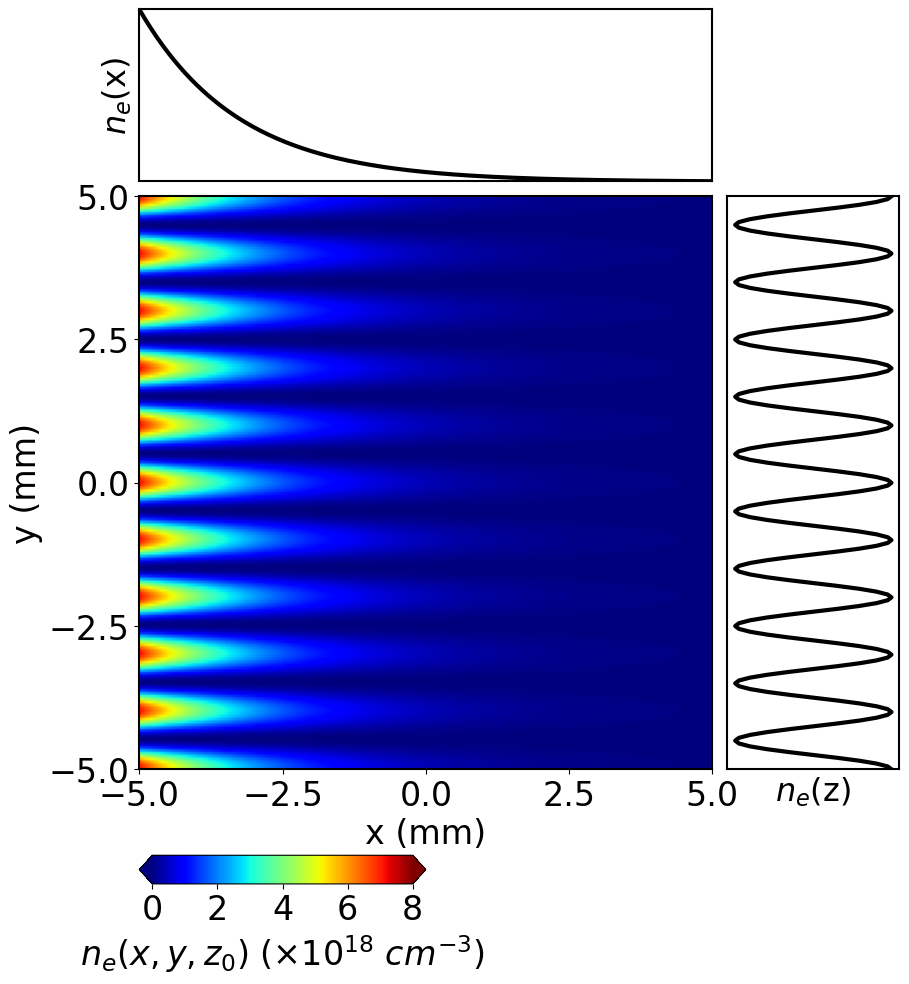

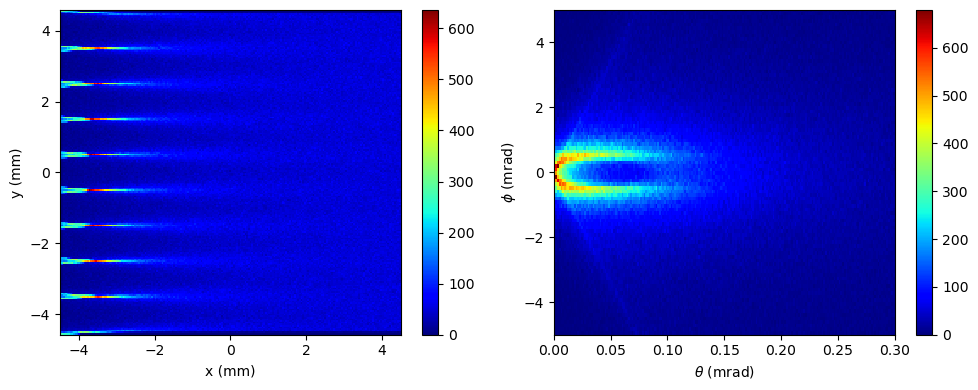

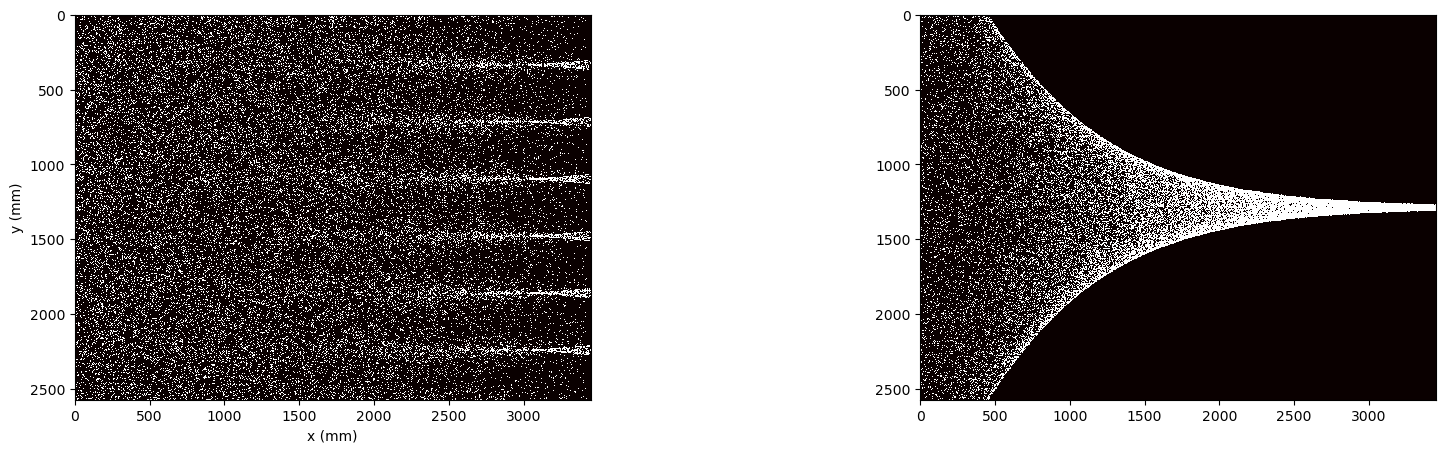

In [7]:
### Add here plots of the output rays in subplots (shadow and refractogram)

graph_domain(cos)

print("Completed updated ray trace in {} seconds for {} rays in a {}^3 domain.".format(duration, Np, M_V))

plot(rf, lwl, l_x = l_x, u_x = u_x, l_y = l_y, u_y = u_y)

Tracing using Legacy Raytracer 

In [8]:
### Add the code here

sys.path.insert(0, '../../src/solvers-legacy')     # import path/to/synthpy

import full_solver as fs
import rtm_solver as rtm

importlib.reload(fs)
importlib.reload(rtm)

slab = fs.ScalarDomain(ne_x, ne_y, ne_z, ne_extent)
slab.test_exponential_cos(n_e0 = 2e17 * 1e6, Ly = 1e-3, s = -4e-3)
slab.calc_dndr(lwl)

## Initialise rays and solve
s0 = fs.init_beam(
    Np, beam_size, divergence, ne_extent,
    probing_direction = probing_direction,
    beam_type = beam_type
)

slab.solve(s0)
rf = slab.rf

Starting ray trace.
Ray trace completed in:	 203.81043910980225 s


Results and time

Completed updated ray trace in 203.81043910980225 seconds for 2000000 rays in a 201^3 domain.

rf size expected: (2000000, 2000000)
rf after clearing nan's: (2000000, 2000000)

rf size expected: (2000000, 2000000)
rf after clearing nan's: (2000000, 2000000)


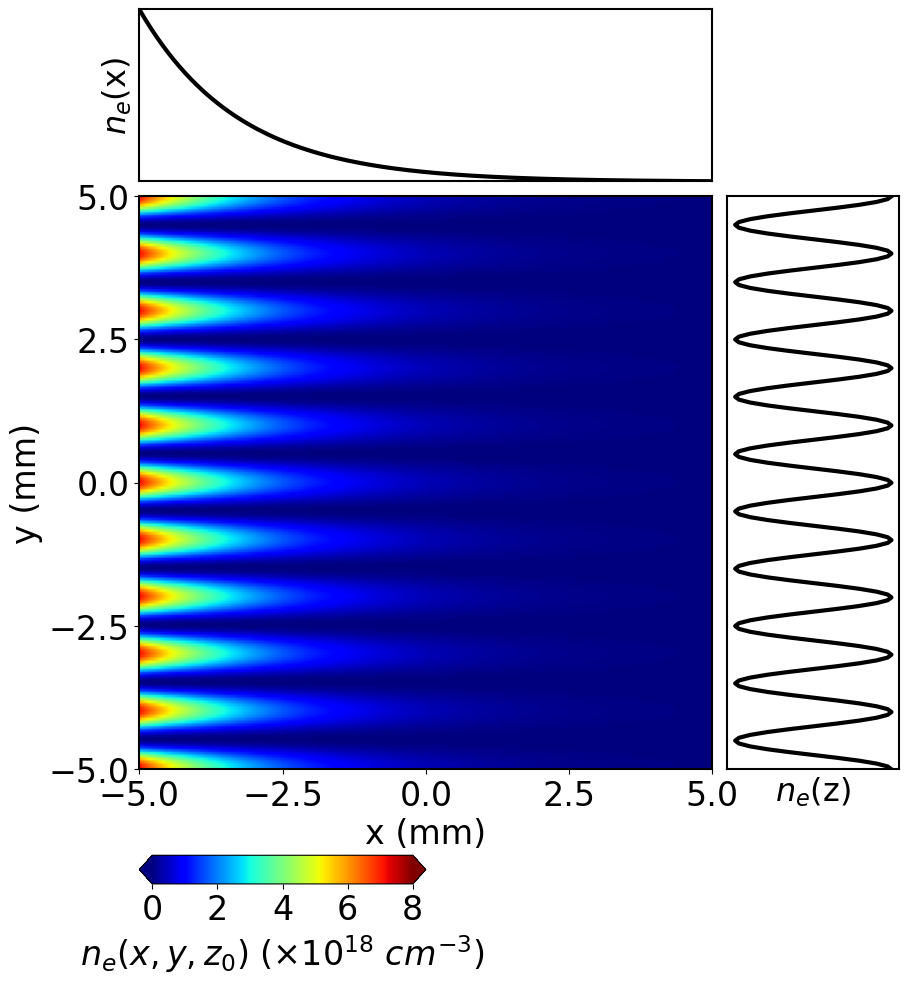

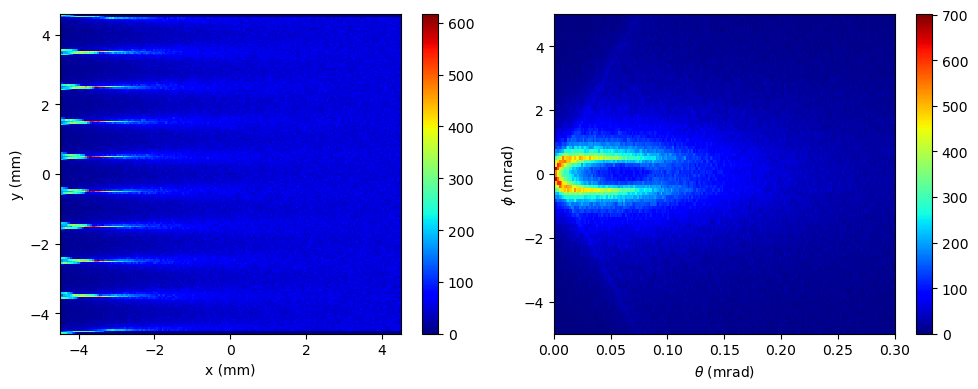

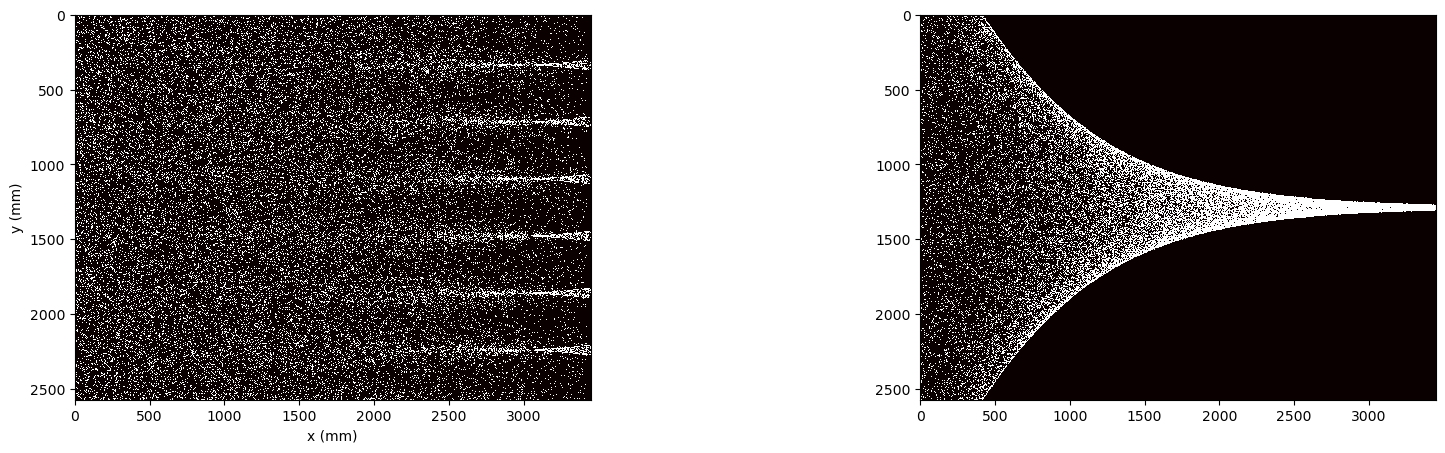

In [9]:
### Add here plots of the output rays in subplots (shadow and refractogram)

graph_domain(slab)

print("Completed updated ray trace in {} seconds for {} rays in a {}^3 domain.".format(slab.duration, Np, M_V))

## Plot
plot(rf, lwl, l_x = l_x, u_x = u_x, l_y = l_y, u_y = u_y)